# fMRI preprocessing Tutorial

Welcome to this week's tutorial, where we'll be learning about high-pass filtering and about adding nuisance variables (both motion correction parameters as physiology retroicor regressors) to our design matrix.

## High-pass filtering

Slow drifts in the scanner signal (caused by all kinds of factors including warming up of the scanner), cause the fMRI signal to also slowly drift over time. Because our GLM does not model this slow drift over time, we need to filter it out of the signal before we start performing GLMs. 

Fourier invented a mathematical way of expressing any time-series as a combination of sines (https://en.wikipedia.org/wiki/Fourier_transform). In this tutorial, we won't go in to the mathematics behind it, but we will try to achieve some level of conceptual understanding about Fourier, and how it can be used to filter out slow drifts.

First, let's import the python packages we'll need.

In [2]:
import numpy as np
import scipy as sp
import nibabel as nb

import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline 

import os

Now, let us define a function that returns a sine wave with certain amplitude, phase and frequency over on certain timepoints

In [3]:
def create_sine_wave(timepoints, frequency=1,amplitude=1, phase=0):
    return amplitude * np.sin(2*np.pi*frequency*timepoints + phase)

### Playing with sinewaves

First, let's create some sinewaves of different frequencies.

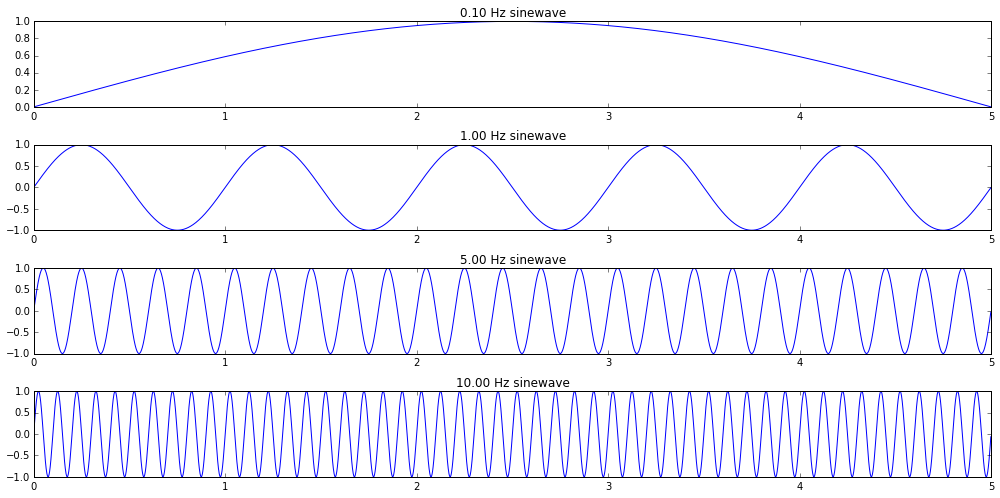

In [4]:
frequencies = [0.1, 1, 5, 10]
num_freqs = len(frequencies)

# now define the timepoints over which over which we want to evaluate the sine function
max_time = 5 #seconds
timesteps = 0.001 #seconds
our_timepoints = np.arange(0,max_time,timesteps)

# create a figure
f = plt.figure(figsize=(14,7))

# let's loop over the frequencies we defined above
for i in range(num_freqs):
    # create a sinewave at this frequency
    sinewave = create_sine_wave(frequency = frequencies[i], timepoints = our_timepoints)
    # create a subplot 
    s = f.add_subplot(num_freqs,1,(i+1)) # add 1 to i because the first subplot should be 1, not 0
    # give it a title using string manipulation
    plt.title('%.2f Hz sinewave'%frequencies[i]) #.2f means a float with 2 decimals
    # and plot the sinewave we created
    plt.plot(our_timepoints,sinewave)    


plt.tight_layout()


The figure above demonstrates what a frequency is: the amount of cycles (from peak to peak) per second. 1 Hz means one cycle per second, and as our timepoints run from 0 to 5 seconds, we see 5 whole cycles in the second subplot, and 50 cycles in the bottom subplot. The 0.1 Hz sinewave is too slow to fully 'finish' in 5 seconds (top subplot).

Because we created the figures above with a for loop, you can change the frequencies in the list at the top of the previous code block to any length you like. Try to change these values and checkout what happens.

Now let's look at the effect of amplitude, which scales the whole sinewave up or down. 

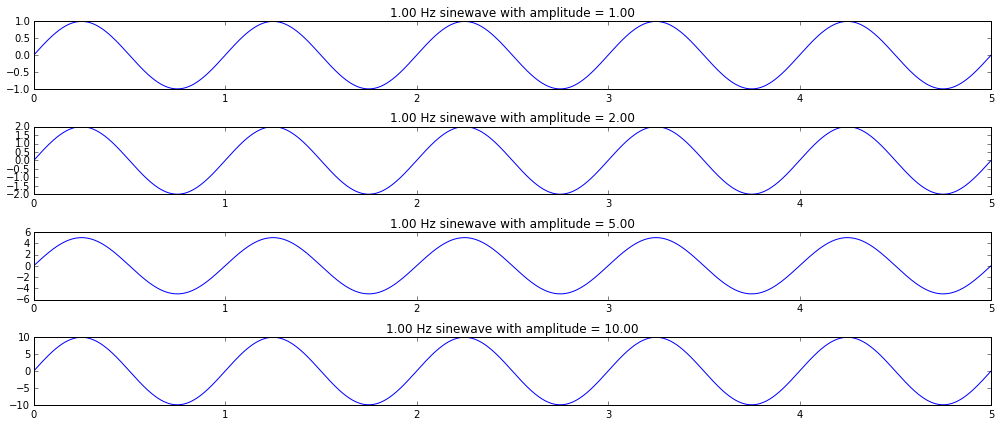

In [5]:
freq = 1
amplitudes = [1,2,5,10]
num_amps = len(amplitudes)

# create a figure
f = plt.figure(figsize=(14,num_amps*1.5))# let figsize depend on number of sines we'll draw

# let's loop over the amplitudes we defined above
for i in range(num_amps):
    # create a sinewave at freq defined above and this amplitude
    sinewave = create_sine_wave(frequency = freq, timepoints = our_timepoints,amplitude = amplitudes[i])
    # create a subplot 
    s = f.add_subplot(num_amps,1,(i+1)) # add 1 to i because the first subplot should be 1, not 0
    # give it a title using string manipulation
    plt.title('%.2f Hz sinewave with amplitude = %.2f'%(freq,amplitudes[i])) #.2f means a float with 2 decimals
    # and plot the sinewave we created
    plt.plot(our_timepoints,sinewave)    

plt.tight_layout()

The effect of amplitude becomes clear by inspecting the y-axis: it scales the sinewave up or down.

Now only one sinewave parameter remains: the phase. The phase reflects the value from peak to peak, and runs from 0 to 2pi. Adding a phase value of pi to a sine function basically 'shifts' it a half cycle to the left. Let's take a look:

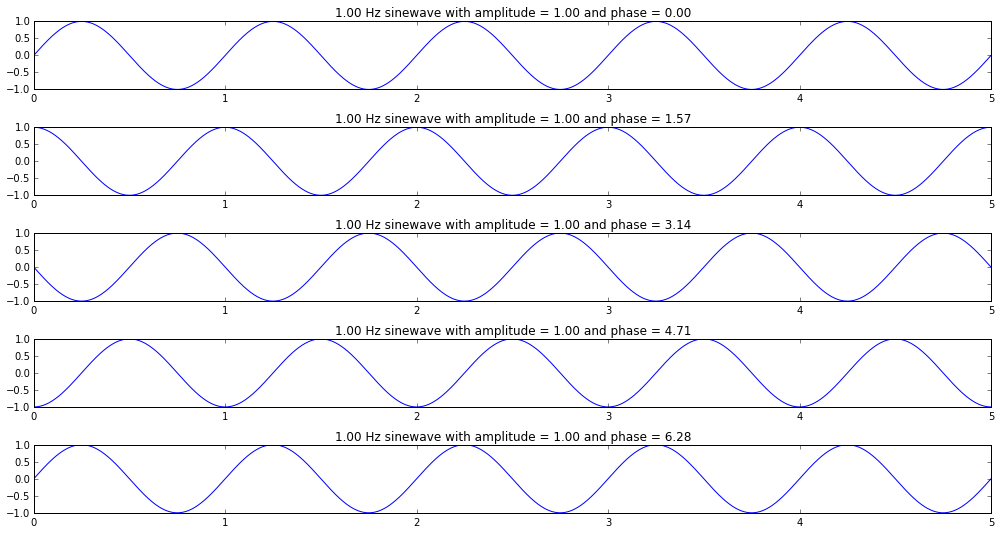

In [6]:
freq = 1
amp = 1
phases = [0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi,] # between 0 and 2 pi (pi = 3.14)
num_phases = len(phases)

# create a figure
f = plt.figure(figsize=(14,num_phases*1.5)) # let the figsize depend on number of sines

# let's loop over the amplitudes we defined above
for i in range(num_phases):
    # create a sinewave at freq defined above and this amplitude
    sinewave = create_sine_wave(timepoints = our_timepoints,phase = phases[i],frequency = freq, amplitude = amp)
    # create a subplot 
    s = f.add_subplot(num_phases,1,(i+1)) # add 1 to i because the first subplot should be 1, not 0
    # give it a title using string manipulation
    plt.title('%.2f Hz sinewave with amplitude = %.2f and phase = %.2f'%(freq,amp,phases[i])) #.2f means a float with 2 decimals
    # and plot the sinewave we created
    plt.plot(our_timepoints,sinewave)    



plt.tight_layout()

Note how the function shifts a half cycle as we keep shifting it with 0.5\*pi. It returns to it's original position after 2\*pi. 

Now that we're familiar with the three sinewave parameters, let's combine a couple of sinewaves to create a complex timeseries.

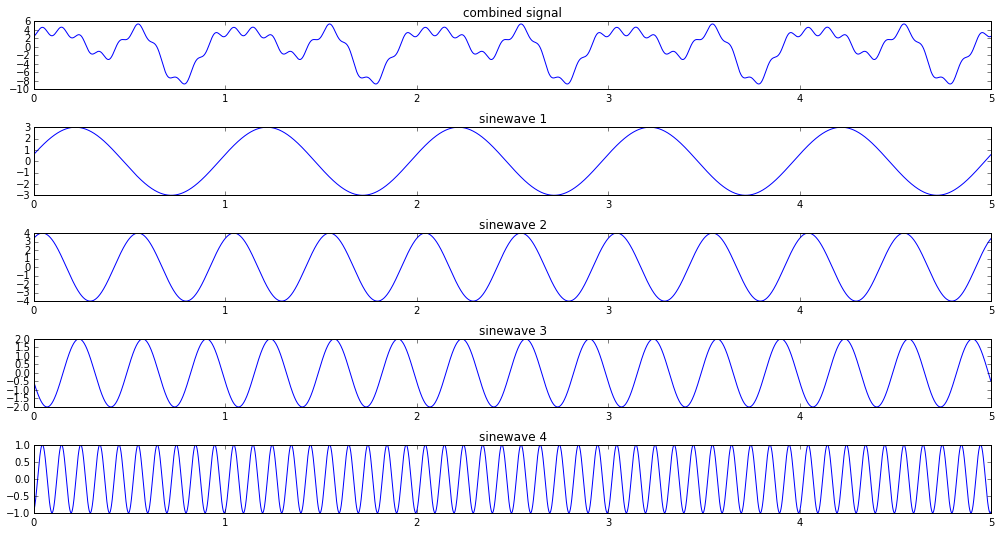

In [7]:
###############################################################################
# change these values, but make sure that all lists have the same length (can be any length):

freqs = [1,2,3,10]
amps = [3,4,2,1]
phases = [0.2,1,3.4,5]

###############################################################################

num_sines = len(freqs) 

# initialize empty array
sines = []
# now loop over the amount of sinewaves we want to create
for i in range(num_sines):
    # create the sinewave using the function we defined at the start
    sine = create_sine_wave(timepoints=our_timepoints,frequency = freqs[i], amplitude = amps[i], phase = phases[i])
    # and append it to our list of sines
    sines.append(sine)
    
# To create our combined signal, we can simply sum all sinewaves:
combined_signal = np.sum(sines,axis=0) # we want to sum over sines, so that's axis 0 (1 is time)

# let's plot the combined signal 
f = plt.figure(figsize=(14,(num_sines+1)*1.5)) # again variable figsize
s = f.add_subplot(num_sines+1,1,1)
plt.title('combined signal')
plt.plot(our_timepoints,combined_signal)

# now loop over all our sinewaves, and plot them underneath
for i in range(num_sines):
    s = f.add_subplot(num_sines+1,1,i+2) # add 2, as the first one is the combined signal
    plt.title('sinewave %d'%(i+1)) # %d fills in integer
    plt.plot(our_timepoints,sines[i])

plt.tight_layout()

Try to change the parameters in the above code block. You can add any number of sines by simply making the lists longer. Do make sure that all lists (freqs, amps, phases) have the same length. Do you see the combined signal changing?

### Fourier analysis: retrieving the combination of sinewaves that make up a signal

Up to now, we created our own 'combined signal', by summing some sinewaves together. In practice however, we always record a timeseries and consecutively want to find the underlying sinewaves making up the signal. For the sake of illustration, let's assume we forgot which sinewaves we used to create the 'combined signal' we created above. Luckily, we still have Fourier to help us retrieve this!

In [8]:
# you don't have to understand the code below:
def fourier_analysis(signal,timestep):

    res = np.abs(np.fft.fft(signal))**2
    freqs = np.fft.fftfreq(signal.size, timestep)
    idx = np.argsort(freqs)
    
    return freqs[idx],res[idx]

Let's use the fourier function above to analyze our combined signal

In [9]:
# this line calls the fourier analysis function 
res_freqs, res_amps = fourier_analysis(combined_signal,timesteps) # we defined timesteps at the start (0.001s)


We now have the frequencies and amplitudes (let's leave out phases for now) of the sinewaves making up our combined_signal. Plotting amplitude on the y-axis and frequency on the x-axis gives us the *power spectrum* of our signal:

our original frequencies were: [1, 2, 3, 10]
our original amplitudes were [3, 4, 2, 1]


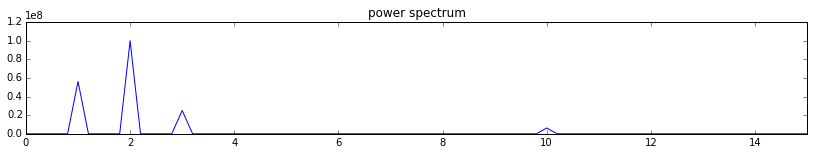

In [10]:
f = plt.figure(figsize=(14,2))
s = f.add_subplot(111)
plt.title('power spectrum')
plt.plot(res_freqs,res_amps)
plt.xlim(0,np.max(freqs)*1.5) # let's only view the powerspectrum up to the maximum frequency we put in 

print 'our original frequencies were:', freqs
print 'our original amplitudes were', amps

You can see that the y-axis here does not match our original frequencies (it is a different measure), but within this power spectrum, you can still compare the relative contributions of the different frequencies.

### Inverse Fourier

Now, the really cool thing about Fourier analysis, is that you can reverse it without losing any information. This means that you can create a timeseries from knowing the phases, amplitudes and frequencies, much like we did above. 

### Using Fourier analysis to filter a signal

We can use Fourier analysis to remove components with certain frequencies from the data. By converting a time-series signal to a power-spectrum, and then selecting which frequencies you do and do not want to keep, and then inverting the fourier transform, we achieved filtering those frequencies out of the original signal (in reality, filtering includes more steps, but we will not go into these in this tutorial; understanding Fourier will suffice here). 

* *high-pass filtering*: removing frequencies lower than a certain threshold
* *low-pass filtering*: removing frequencies higher than a certain threshold
* *band-pass filtering*: Only allowing frequencies between two thresholds

Let's try this out on actual data. From here on, you'll need the file from blackboard called 'week_5_material'. Download this zip file and extract it. Below, make sure that the path points to the extracted folder.

In [11]:
# this should point to the folder you downloaded and extractd from blackboard:
datafolder = '/Users/daanvanes/Documents/Documenten/Research/courses/BrainImaging/week_5/week_5_material/'
# load the data
voxel_with_strong_drift = np.load(os.path.join(datafolder,'voxel_with_strong_drift.npy'))
# hard-code the TR for ease
TR = 1.6


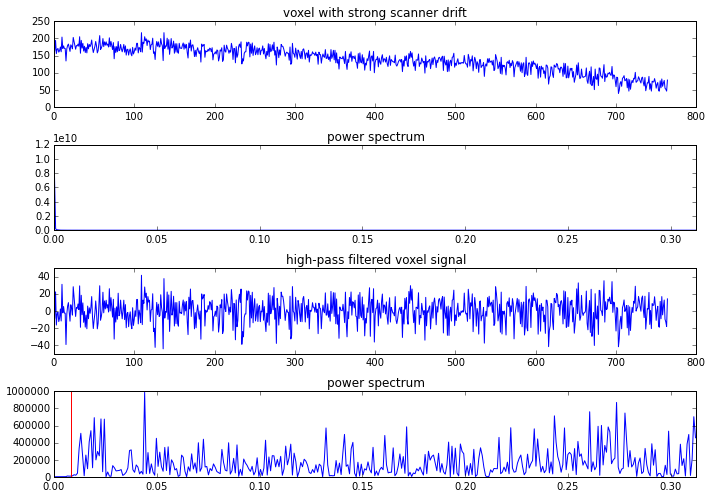

In [12]:
# let's first plot this drifting voxel
f = plt.figure(figsize=(10,7))
s = f.add_subplot(411)
plt.title('voxel with strong scanner drift')
plt.plot(voxel_with_strong_drift)

# now let's run the fourier analysis on this signal
res_freqs, res_amps = fourier_analysis(voxel_with_strong_drift,TR)

# and plot the power-spectrum
s = f.add_subplot(412)
plt.title('power spectrum')
plt.plot(res_freqs,res_amps)
# the maximum frequency we can measure is 0.5*samplerate
# this is called the nyquist frequency
nyquist = 0.5*(1/TR)
plt.xlim(0,nyquist) # let's plot only frequencies up to the nyquist frequency

# now let's high-pass filter the signal.
from scipy import signal
window_size = int(120/TR) # this is the high pass-threshold: 120 seconds, so that is 1/120 = 0.0083 Hz
# this line performs the high-pass filter:
high_pass = voxel_with_strong_drift - signal.savgol_filter(x=voxel_with_strong_drift,polyorder=2,window_length=window_size)

# and plot the result
s = f.add_subplot(413)
plt.title('high-pass filtered voxel signal')
plt.plot(high_pass)

# now let's run the fourier analysis on this signal
res_freqs, res_amps = fourier_analysis(high_pass,TR)

# and plot the power-spectrum
s = f.add_subplot(414)
plt.title('power spectrum')
plt.plot(res_freqs,res_amps)
plt.xlim(0,nyquist)
plt.axvline(1/120.,color='r')

plt.tight_layout()


You can see how the power spectrum in the second subplot is completely dominated by this low frequency drift. By high-pass filtering the signal, we only allowed those sine-waves that completed a cycle in less than 120 seconds (which corresponds to 1/120 = 0.0083 Hz, red line). Signals slower than this are considered to be impossibly conceived by physiology and thus safe to remove. 

## Adding nuisance variables to your design matrix

In order to convert Beta-values to t-stats, we need to divide them by the standard error of the residuals. The residuals are computed by subtracting the data from the model prediction, squaring all of these values and summing them up. In other words, the higher your residuals, the lower your t-values and thus the lower your statistical power. In order to boost statistical power, we have to model as much as possible in the signal. We can achieve this by adding more regressors to our design matrix that try and capture known sources of noise such as heartbeat and respiration and also motion correction parameters.

### Clean GLM

I preselected a voxel for this tutorial that contains large motion artifacts. Let's first take a look at the data.

(0, 1224.0)

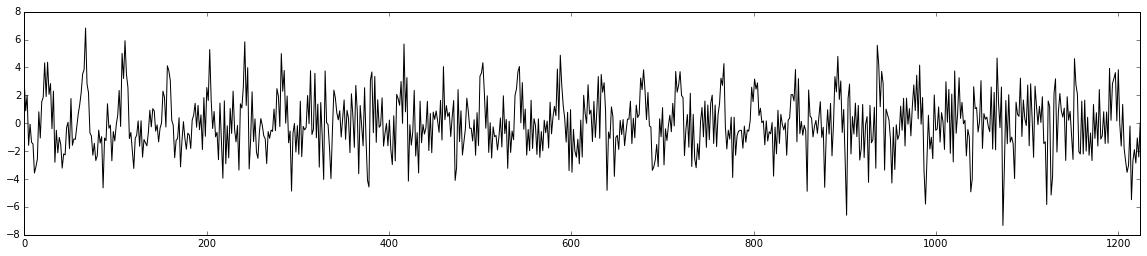

In [35]:

# load the data
data = np.load(os.path.join(datafolder,'noisy_voxel.npy'))
TR = 1.6
timepoints = np.linspace(0,len(data)*TR,len(data))

# and plot to inspect
f = plt.figure(figsize=(20,4))
s = f.add_subplot(111)
plt.plot(timepoints,data,'k')
plt.xlim(0,np.max(timepoints))


Inspecting the plot above, we find that the data spans a period of roughly 1200 seconds, or 20 minutes. We can see a clear response here and there (especially at the start), but we also see a lot of high-frequency noise. 

Let's first run a standard GLM, with no added parameters to see how well our model performs. I've saved convolved regressors, so we don't have to create these anymore.

In [36]:
# load the regressors
regressors_of_interest = np.load(os.path.join(datafolder,'regressors_of_interest.npy'))
print regressors_of_interest.shape

(3, 765)


Apparantely we have 3 regressors of interest, and we still need to add an intercept regressor.

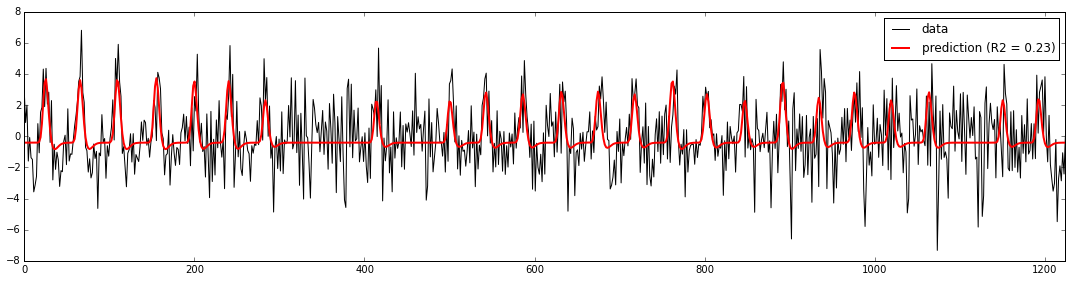

In [37]:
# create a design matrix with both the intercept regressor and the ones we loaded already
design_matrix = np.vstack([np.ones(np.shape(data)[0]),regressors_of_interest]) #vstack stacks arrays vertically

# now perform the glm
betas, _sse, _r, _svs = np.linalg.lstsq(design_matrix.T, data.T )

# let's create our prediction by multiplying all regressors with it's beta, and then sum these together
total_prediction = np.squeeze(np.array(np.sum(np.mat(betas)*np.mat(design_matrix),axis=0))) # squeeze removes empty dimension
# compute the r_squared:
r_squared = 1.0 - np.sum((data - total_prediction)**2)/np.sum((data - np.mean(data))**2)

# now let's plot the data and the prediction together
f = plt.figure(figsize=(15,4))
s = f.add_subplot(111)
plt.plot(timepoints,data,'k',label='data')
plt.plot(timepoints,total_prediction.T,'r',lw=2,label='prediction (R2 = %.2f)'%r_squared)
plt.xlim(0,np.max(timepoints))
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.tight_layout()



You can see that the model already predicts the data reasonably well (23% of data predicted by model), but a lot of noise still remains unexplained.

### Motion correction parameters in GLM
Let's see if we can do something about that, by adding the motion correction parameters to the design matrix. First, let's inspect them.

In [16]:
# load the motion correction parameters 
moco_params = np.load(os.path.join(datafolder,'motion_correction_parameters.npy'))
moco_params.shape


(765, 6)

There are 6 motion correction parameters. They correspond to: translation and rotation in the x,y and z dimension. Let's plot them to get an idea.

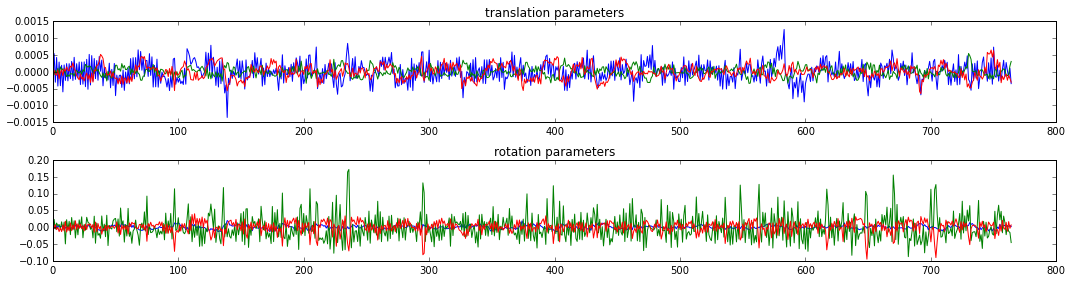

In [17]:
f = plt.figure(figsize=(15,4))
s = f.add_subplot(211)
plt.title('translation parameters')
plt.plot(moco_params[:,:3]) # plot the first three parameters
s = f.add_subplot(212)
plt.title('rotation parameters')
plt.plot(moco_params[:,3:]) # plot the second three parameters

plt.tight_layout()


Now, let's try to add these parameters as regressors to our design matrix, and see if our prediction improves.

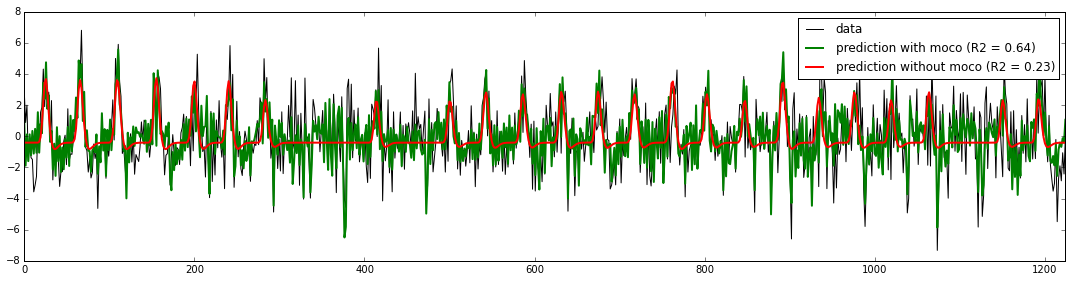

In [18]:
# same line as above, but now with the 6 moco_params added
design_matrix = np.vstack([np.ones(np.shape(data)[0]),regressors_of_interest,moco_params.T]) #vstack stacks arrays vertically

# now perform the glm
betas, _sse, _r, _svs = np.linalg.lstsq(design_matrix.T, data.T )

# let's create our prediction by multiplying all regressors with it's beta, and then sum these together
total_prediction_with_moco = np.squeeze(np.array(np.sum(np.mat(betas)*np.mat(design_matrix),axis=0))) # squeeze removes empty dimension
# compute the r_squared:
r_squared_moco = 1.0 - np.sum((data - total_prediction_with_moco)**2)/np.sum((data - np.mean(data))**2)

# now let's plot the data and the prediction together
f = plt.figure(figsize=(15,4))
s = f.add_subplot(111)
plt.plot(timepoints,data,'k',label='data')
plt.plot(timepoints,total_prediction_with_moco,'g',lw=2,label='prediction with moco (R2 = %.2f)'%r_squared_moco)
plt.plot(timepoints,total_prediction,'r',lw=2,label='prediction without moco (R2 = %.2f)'%r_squared)
plt.xlim(0,np.max(timepoints))
# add legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.tight_layout()

You can see the old prediction in red, and the new prediction in green. This looks a lot better! We're now capturing a lot of noise in the data, which is reflected by an increase of about 40% added variance explained. 

### Physiology regressors in the GLM

Another source of variance in fMRI data are those created by the heartbeat and respiration. Retroicor is an FSL feature that converts the heartbeat and respiration signals recorded within the scanner into a multitude of regressors. Let's take a look at them. 


In [19]:
retroicor_regressors = np.load(os.path.join(datafolder,'retroicor_regressors.npy'))
print retroicor_regressors.shape

(34, 765)


So, we have 34 retroicor regressors. The first 6 reflect heartbeat regressors, the next 4 are respiratory regressors and the rest is interactions between cardiac and hearbeat regressors. Let's plot the first 10 to get an idea. 

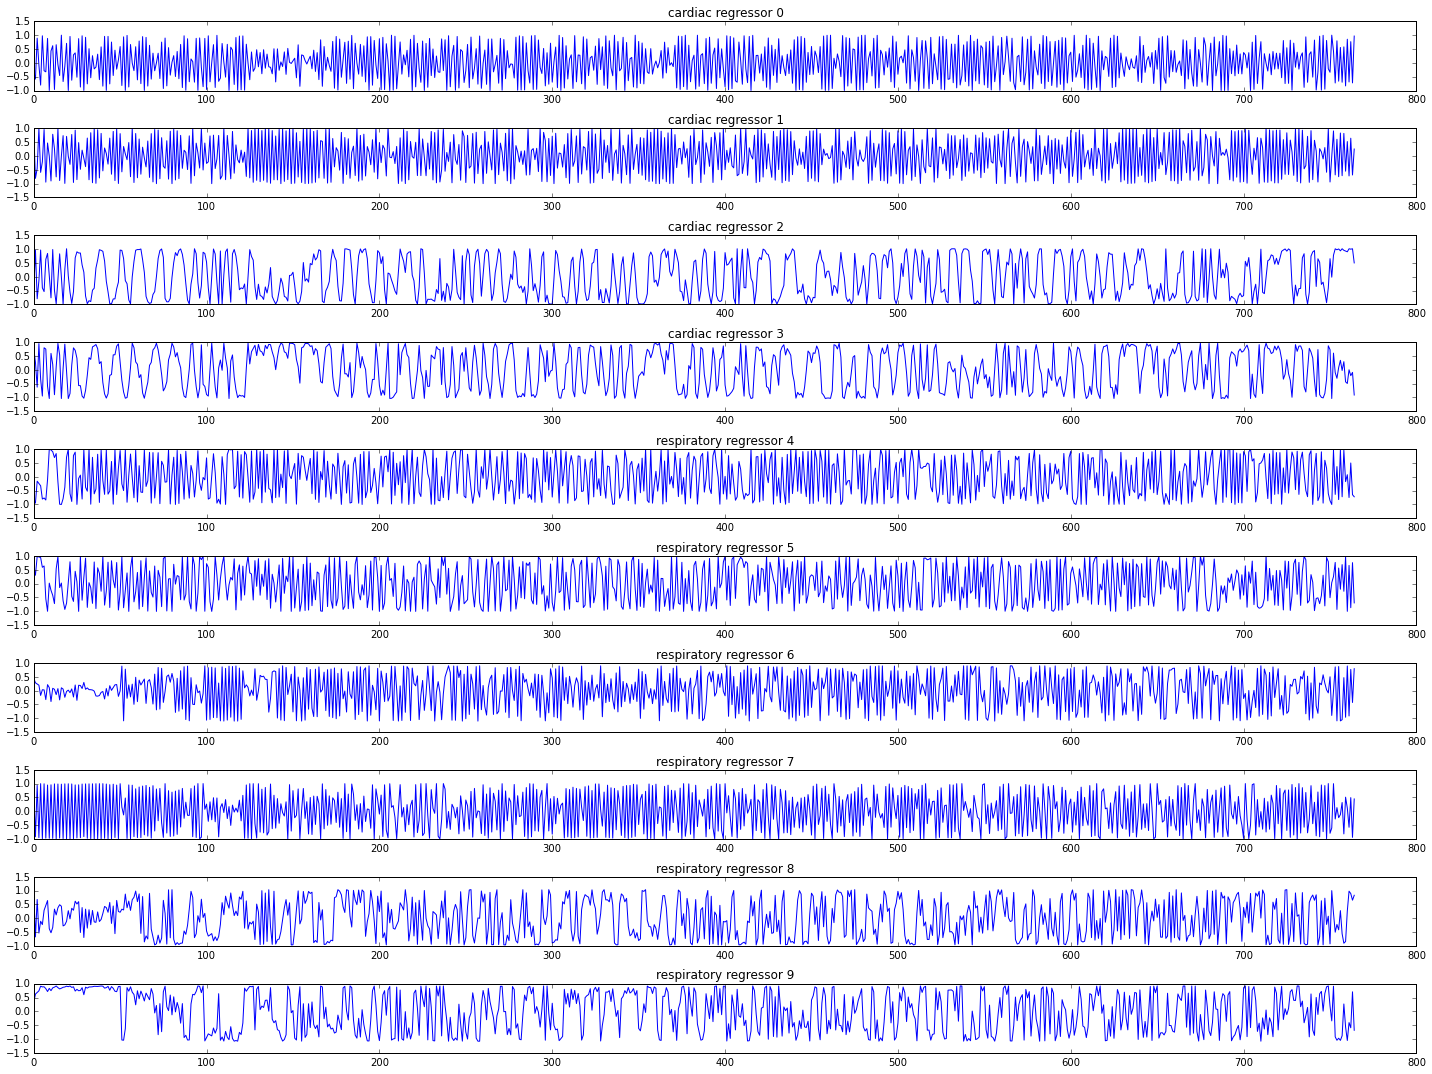

In [20]:
f = plt.figure(figsize=(20,15))
for i in range(4): # the first 4 are cardiac
    s = f.add_subplot(10,1,i+1)
    plt.title('cardiac regressor %d'%i)
    plt.plot(retroicor_regressors[i,:]) 
for i in range(4,10): # the respiratory regressors
    s = f.add_subplot(10,1,i+1)
    plt.title('respiratory regressor %d'%i)
    plt.plot(retroicor_regressors[i,:]) 

plt.tight_layout()

It's hard to really understand what these regressors reflect, but at least in the first two we seem to view something that looks like a heartbeat. Now then, let's add them to our design matrix and see how much this helps.

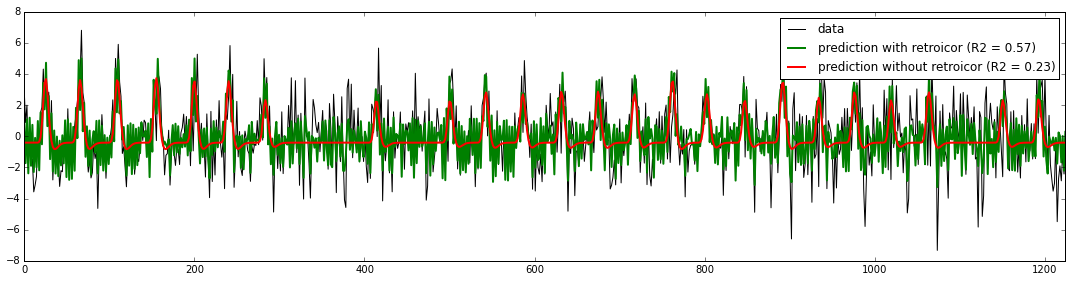

In [21]:
# same as above, but now with the 34 retroicor regressors added
design_matrix = np.vstack([np.ones(np.shape(data)[0]),regressors_of_interest,retroicor_regressors]) #vstack stacks arrays vertically

# now perform the glm
betas, _sse, _r, _svs = np.linalg.lstsq(design_matrix.T, data.T )

# let's create our prediction by multiplying all regressors with it's beta, and then sum these together
total_prediction_with_moco = np.squeeze(np.array(np.sum(np.mat(betas)*np.mat(design_matrix),axis=0))) # squeeze removes empty dimension
# compute the r_squared:
r_squared_moco = 1.0 - np.sum((data - total_prediction_with_moco)**2)/np.sum((data - np.mean(data))**2)

# now let's plot the data and the prediction together
f = plt.figure(figsize=(15,4))
s = f.add_subplot(111)
plt.plot(timepoints,data,'k',label='data')
plt.plot(timepoints,total_prediction_with_moco,'g',lw=2,label='prediction with retroicor (R2 = %.2f)'%r_squared_moco)
plt.plot(timepoints,total_prediction,'r',lw=2,label='prediction without retroicor (R2 = %.2f)'%r_squared)
plt.xlim(0,np.max(timepoints))
# add legend
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.tight_layout()


Again, we can see a tremendous increase in our R-squared, indicating that we were able to get rid of a lot of noise!

In the exercise, you will be adding more motion correction parameters, and you will also be combining both the motion correction and retroicor regressors in the design matrix, to see how much of the noise we can eliminate!